In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from scipy import stats
import warnings
from TESStools import *
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
tid = 279957111

Text(0, 0.5, 'Normalized Flux')

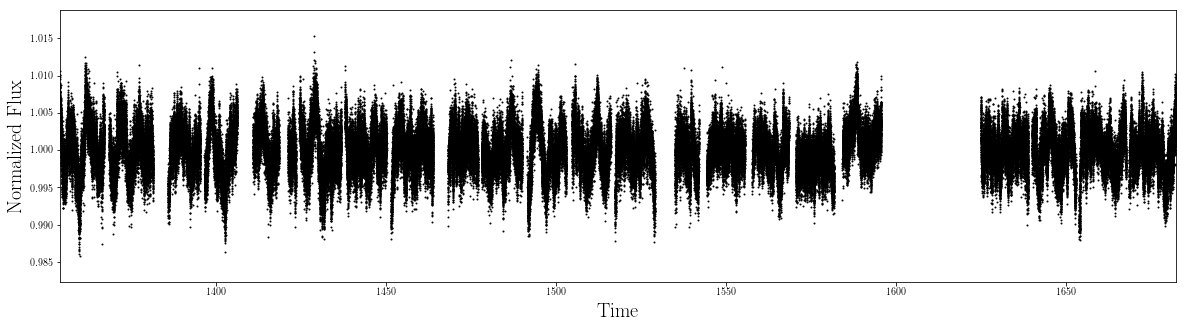

In [34]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=512)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
fig = plt.figure(figsize=(20,5))
plt.scatter(time,flux,s=1,c='k')
plt.xlim(np.min(time),np.max(time))
np.max(time) - np.min(time)
plt.xlabel('Time',fontsize=20)
plt.ylabel('Normalized Flux',fontsize=20)

In [4]:
#sliding window periodogram
def sliding_periodogram(time, flux, err=None, window=15.0, dt=1.0, max_f=5.0):
    """
    A sliding window periodogram. Calculated over a window of width `window` days,
    every `dt` days
    
    Parameters
    ----------
    time : array-like
        times
    flux : array-like
        fluxes
    err : array-like
        errors, optional
    window : float
        width of sliding window
    dt : float
        size of step over the window
    max_f : float
        maximum frequency to calculate the Lomb-Scargle periodogram
        
    Returns
    -------
    ts : array-like
        Time values of sliding periodogram
    freq : array-like
        Frequency grid of `periodograms`
    periodograms : array-like
        Periodograms. Each entry is a periodogram corresponding to a time in `ts`. Shape is
        `(len(ts),len(freq))`
    
    """
    
    min_t = np.min(time)#+(window/2.0)
    max_t = np.max(time)#-(window/2.0)
    
    n_dt = np.floor((max_t-min_t) / dt)
    start = min_t
    stop = min_t+(n_dt*dt)
    num = int(n_dt+1)
    ts = np.linspace(start,stop,num=num)
    periodograms = []
    for i,t in enumerate(ts):
        condition = (time >= t-(window/2.0))&(time < t+(window/2.0))
        wtime = time[condition]
        wflux = flux[condition]
        if err is not None:
            werr = err[condition]
            ls = LombScargle(wtime,wflux,dy=werr)
        else:
            ls = LombScargle(wtime,wflux)
        if i == 0:
            freq,power = ls.autopower(maximum_frequency=max_f)
        else:
            power = ls.power(freq)
        periodograms.append(power)
    periodograms = np.array(periodograms)
    
    return ts, freq, periodograms

/Users/carina/anaconda/lib/python3.5/site-packages/astropy/stats/lombscargle/implementations/main.py:218: RuntimeWarning: invalid value encountered in double_scalars
  PLS = METHODS[method](*args, **kwds)


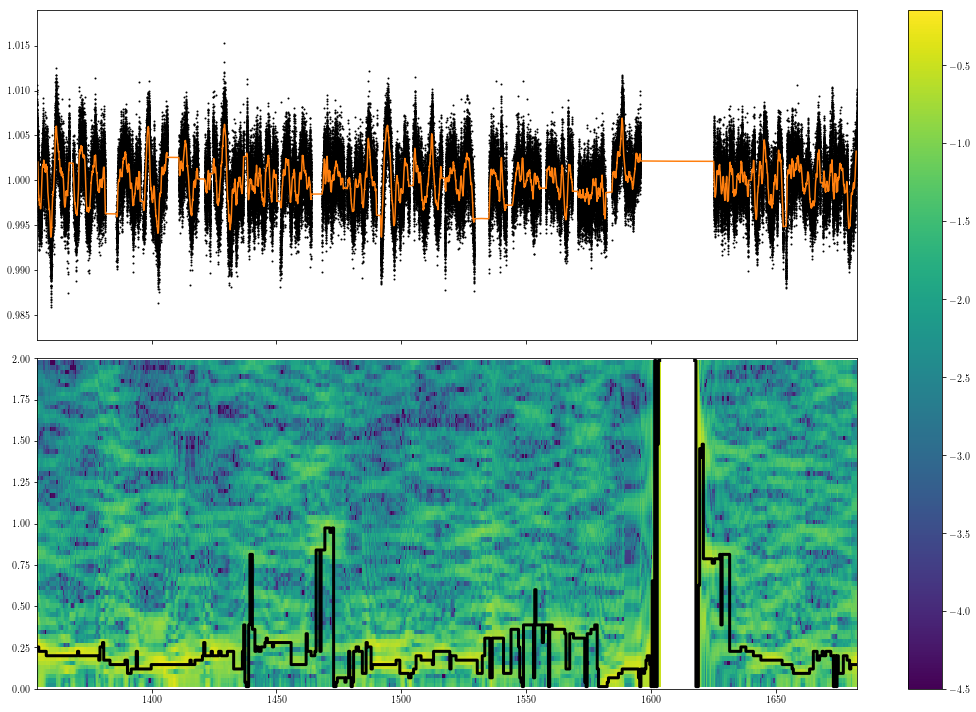

In [41]:
ts, freq, periodograms = sliding_periodogram(time,flux,err,window=15.0,dt=0.5,max_f=2.0)
fig,ax = plt.subplots(2,figsize=(15,10),sharex=True)
ax[0].scatter(time,flux,s=1,c='k')
ax[0].plot(lc_smooth['Time'],lc_smooth['Flux'],c='C1')
mesh = ax[1].pcolormesh(ts,freq,np.log10(periodograms.T),vmin=-4.5)
ax[0].set(xlim=(min(time),max(time)))
max_peak = [freq[p==m][0] if not np.isnan(m) else np.nan for p,m in zip(periodograms,np.max(periodograms,axis=1))]
ax[1].step(ts,max_peak,c='k',lw=3,where='mid')
ax[1].set(ylim=(0,2))
fig.tight_layout()
plt.colorbar(mappable=mesh,ax=ax)

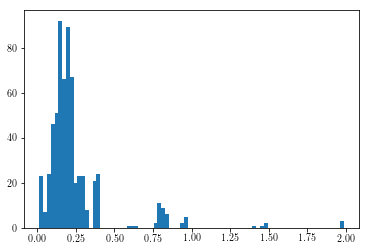

In [43]:
plt.hist(np.array(max_peak)[~np.isnan(max_peak)],bins='auto');

In [13]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3
S0 = np.var(flux) / (w0 * Q)
bounds = dict(log_S0=(-40, 30), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 2*np.pi/4.9
S0 = np.var(flux) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

kernel += terms.JitterTerm(log_sigma=np.log(np.median(err)),
                               bounds=[(-20.0, 5.0)])

gp = celerite.GP(kernel, mean=np.mean(flux))
gp.compute(time, err)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def grad_neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(y)[1]

bounds = gp.get_parameter_bounds()
initial_params = gp.get_parameter_vector()


from scipy.optimize import minimize

gp.compute(time, err)
print('minimizing')
soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                    method="L-BFGS-B", bounds=bounds, args=(flux, gp))
print('minimized')
gp.set_parameter_vector(soln.x)
initial_params = soln.x

Initial log likelihood: 878059.9499331226
minimizing


/Users/carina/anaconda/lib/python3.5/site-packages/autograd/numpy/numpy_extra.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return A[idx]


minimized


In [17]:
len(time[::100]),len(flux[::100])

(1798, 1798)

In [ ]:
print('predicting')
mu, var = gp.predict(flux, time, return_var=True)
print('predicted')
std = np.sqrt(var)
    
plt.scatter(time,flux)
plt.plot(time[::100],mu)
plt.fill_between(time, mu-std, mu+std)

predicting


In [10]:
#gp.predict(flux[::1000], time[::1000], return_var=True)
flux[::1000].values

array([1.0014005 , 0.9987037 , 0.9978372 , 0.99991846, 0.9924461 ,
       0.9996959 , 1.0056069 , 1.0050632 , 0.99672395, 1.0065501 ,
       0.9985561 , 0.99873036, 1.0040537 , 1.0008223 , 0.9981474 ,
       1.0023253 , 0.9978589 , 0.9979939 , 0.9974271 , 1.0008004 ,
       1.0025152 , 1.0018151 , 0.9994641 , 0.9936118 , 1.0014904 ,
       0.9948269 , 1.0029888 , 1.0003896 , 1.0018758 , 0.9966133 ,
       1.0018661 , 1.0022084 , 1.0025898 , 1.0007402 , 1.003304  ,
       0.9984148 , 0.99871147, 0.99831086, 1.0019255 , 0.99918723,
       0.997418  , 1.0025693 , 1.0048032 , 0.9907226 , 0.994841  ,
       0.99920666, 0.99996066, 1.0012736 , 0.9968448 , 1.0036032 ,
       1.000921  , 1.0017755 , 0.99942774, 1.003175  , 1.0020659 ,
       1.0007937 , 1.0009363 , 1.0008354 , 1.0029855 , 1.0021361 ,
       0.9976797 , 0.9959054 , 1.0001558 , 1.0005419 , 0.9990049 ,
       0.9984254 , 1.0011232 , 0.9982218 , 1.0020436 , 1.0028827 ,
       1.0009043 , 1.0015074 , 0.9987147 , 1.0009485 , 1.00090

(0.03333333333333333, 273.77700914002446)

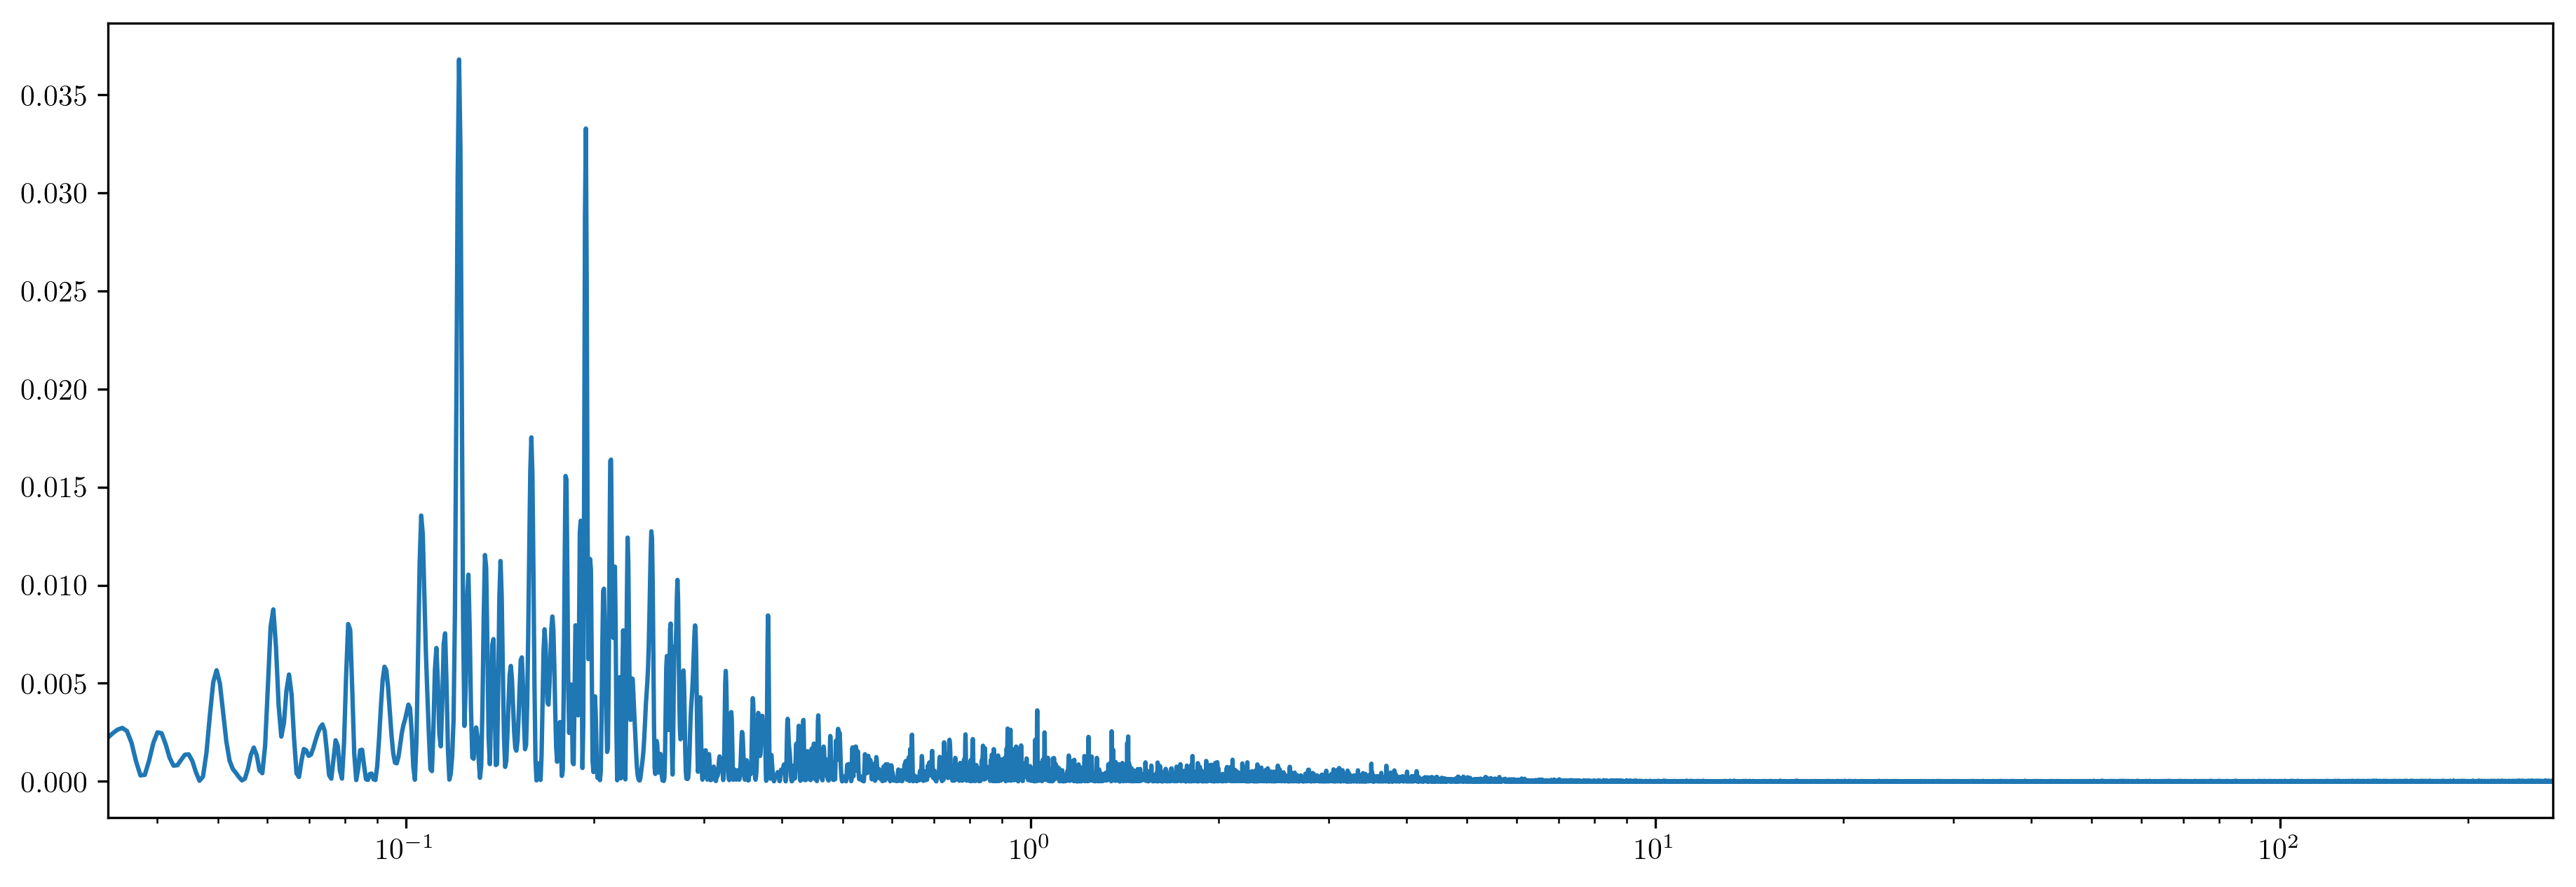

In [12]:
fig = plt.figure(figsize=(15,5),dpi=300)
pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 
plt.plot(freq,power)
plt.xscale('log')
plt.xlim(1/30,pseudo_NF)

In [13]:
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']

pseudo_NF = 0.5 / (np.mean(np.diff(time)))
ls = LombScargle(time, flux, normalization='psd')
freq, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF) 

good_fs, good_amps, good_phases = prewhiten(time, flux, err)
harmonics = harmonic_search(good_fs)
combos = combo_search(good_fs)

f_Ny = 273.77700914002446, f_R = 0.003046485722043525
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
Found 673 frequencies
462 unique frequencies


In [18]:
harmonics

array([[ 0.12173498,  0.15896004,  0.13390129,  0.27846496,  0.22682364,
         0.05075461,  0.33139508,  0.35928436,  0.29587911,  0.25749955,
         0.25749955,  0.66987321,  1.05324006,  0.08700194,  0.44871348,
         0.44261437,  0.55365994,  0.03585803,  0.42260545,  0.42260545,
         0.56499603,  0.56499603,  0.50568045,  0.65364213,  0.46942359,
         0.24031106,  0.14283831,  0.39181888,  0.59817536,  0.84508052,
         1.24598857,  1.78750758,  0.07628831,  1.3280963 ,  1.07470441,
         0.62047027,  0.40134881,  0.40134881,  1.92446532,  2.07565629,
         0.41752529,  1.68039287,  1.61149312,  1.61149312,  1.80024774,
         0.23397726,  0.58240661,  1.68799166,  0.57331249,  0.57331249,
         0.35219878,  0.35219878,  0.20087207,  0.12895188,  2.60727065,
         0.46238436,  0.05571717,  0.73242407,  1.26353353,  0.74691131,
         1.01258465,  0.63717557,  0.63717557,  0.63717557],
       [ 0.85206761,  1.27165373,  0.40134881,  1.67064272,  1.

In [5]:
combos

array([[0.20327588, 0.20327588, 0.11705849, 0.27226816, 1.04145053,
        1.04145053, 1.24393495],
       [1.04145053, 1.1308004 , 1.48653861, 1.33240989, 2.30579937,
        2.15944146, 1.95391049],
       [1.24393495, 1.33240989, 1.60232584, 1.60232584, 3.3470861 ,
        3.19875548, 3.19875548]])

Text(0.5, 1.0, 'HD 269582')

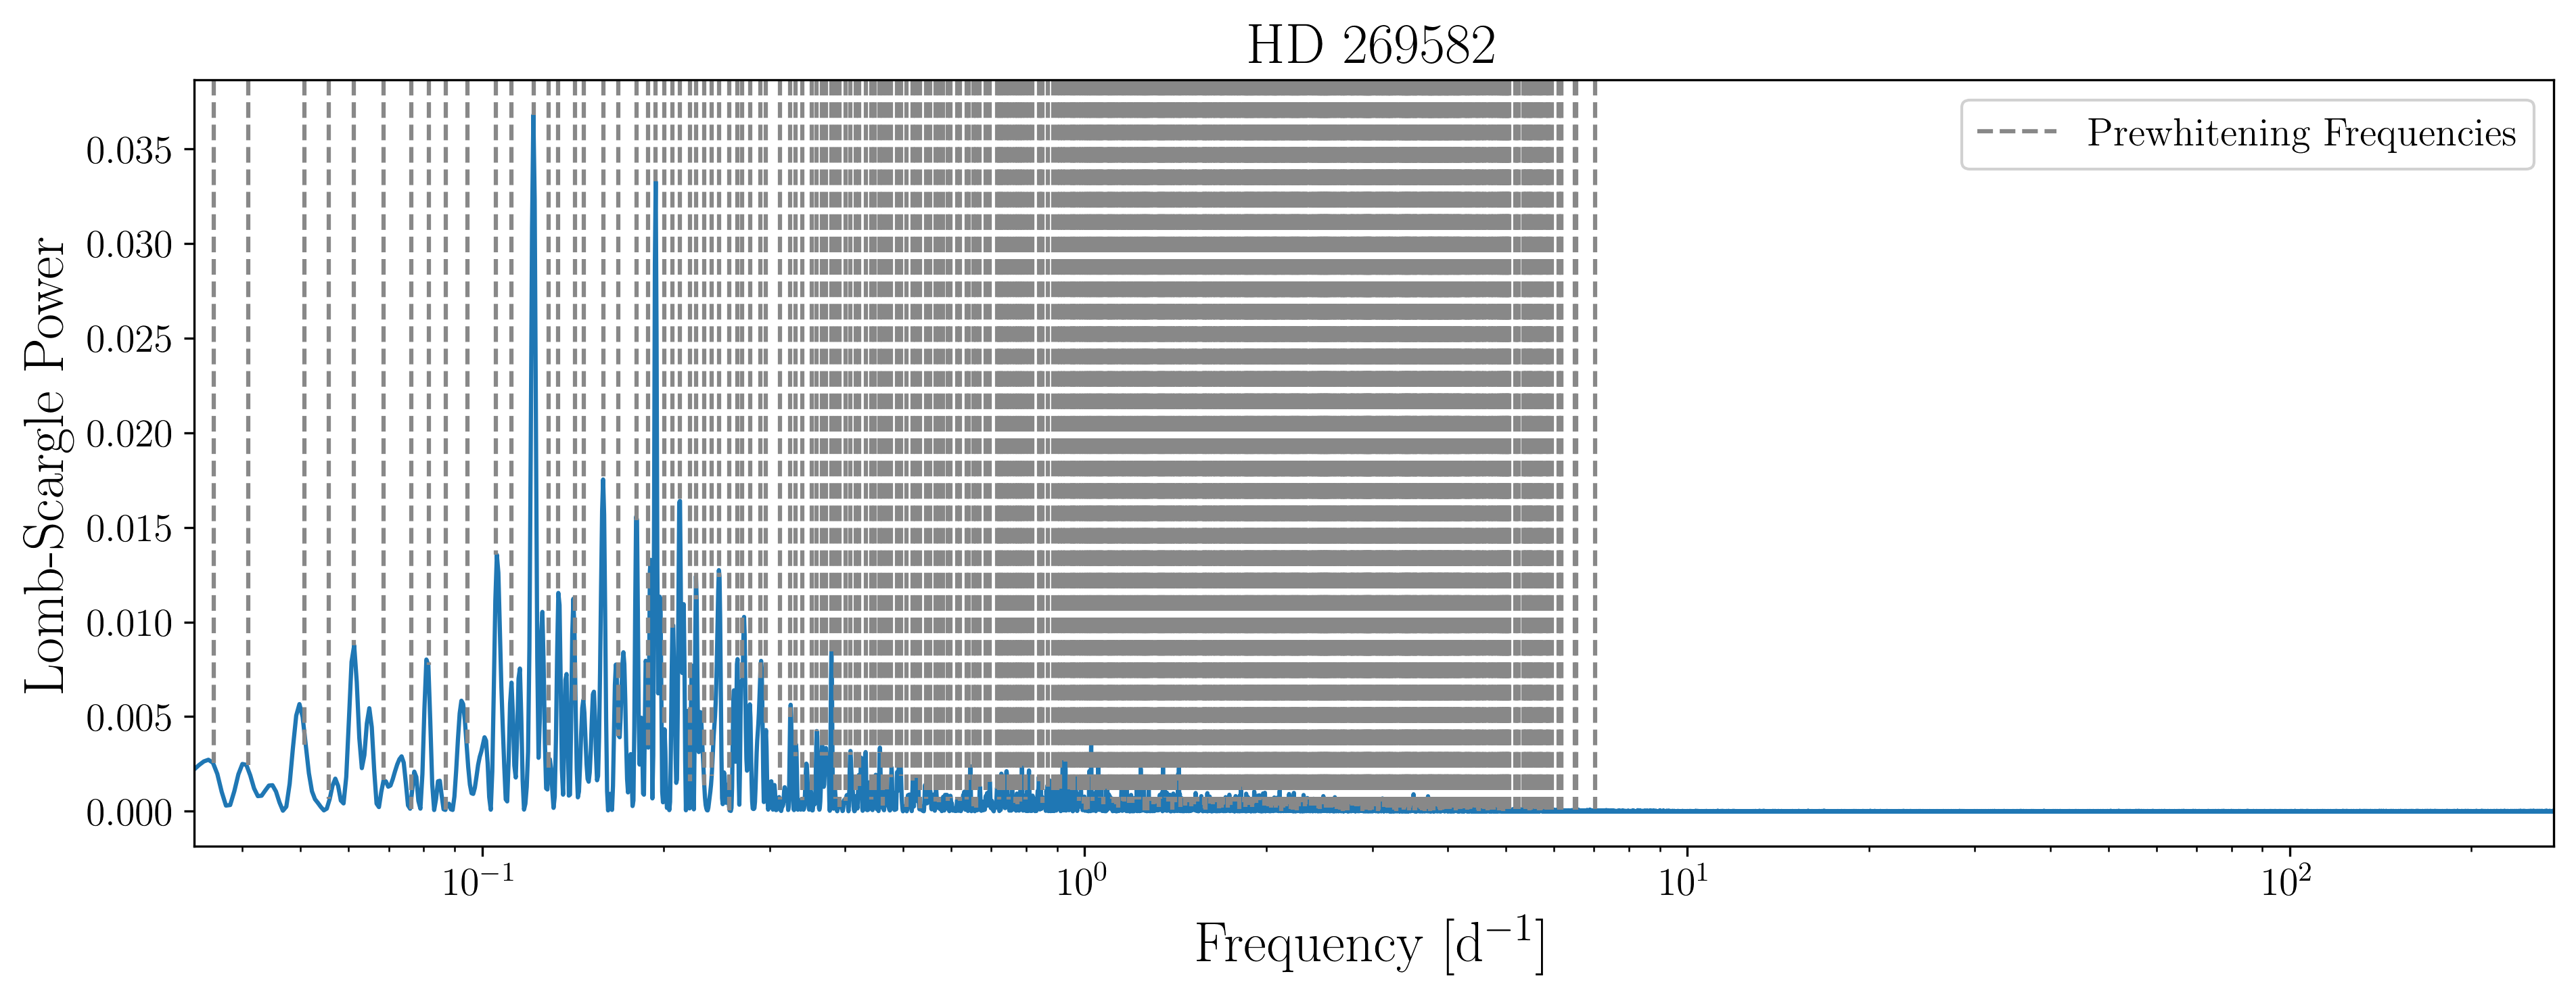

In [19]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
       
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 269582',fontsize=20)    
#plt.savefig('../plots/HD269582_periodogram.pdf')

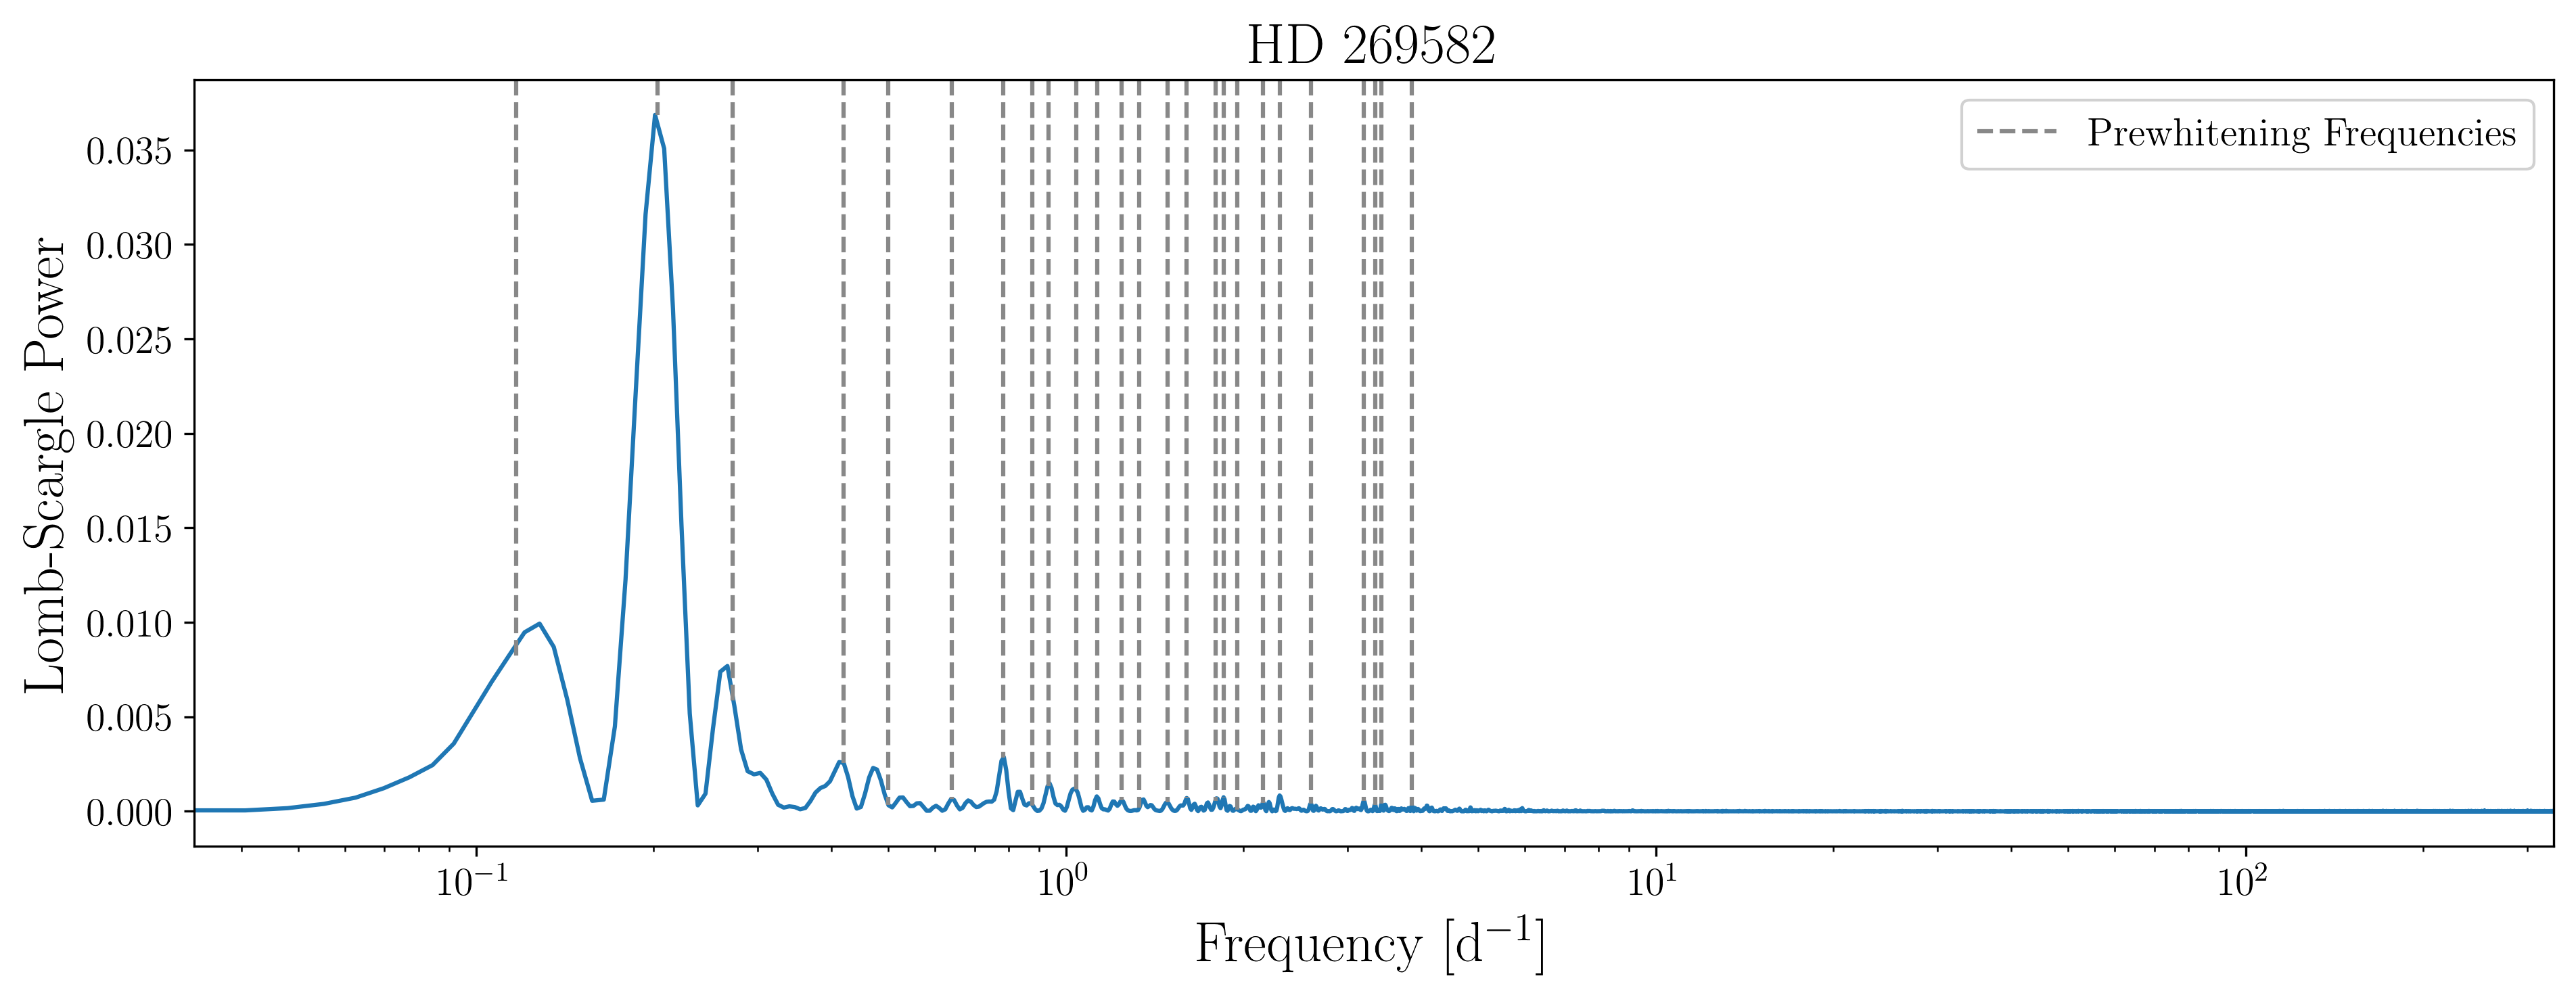

In [6]:
fig = plt.figure(figsize=(15,5),dpi=300)

plt.plot(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]', ylabel='Lomb-Scargle Power', xscale='log', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
       
ax.set(ylim=ylim)
        
plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 269582',fontsize=20)    
#plt.savefig('../plots/HD269582_periodogram.pdf')

In [7]:
dom = 0.2032758787381713

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


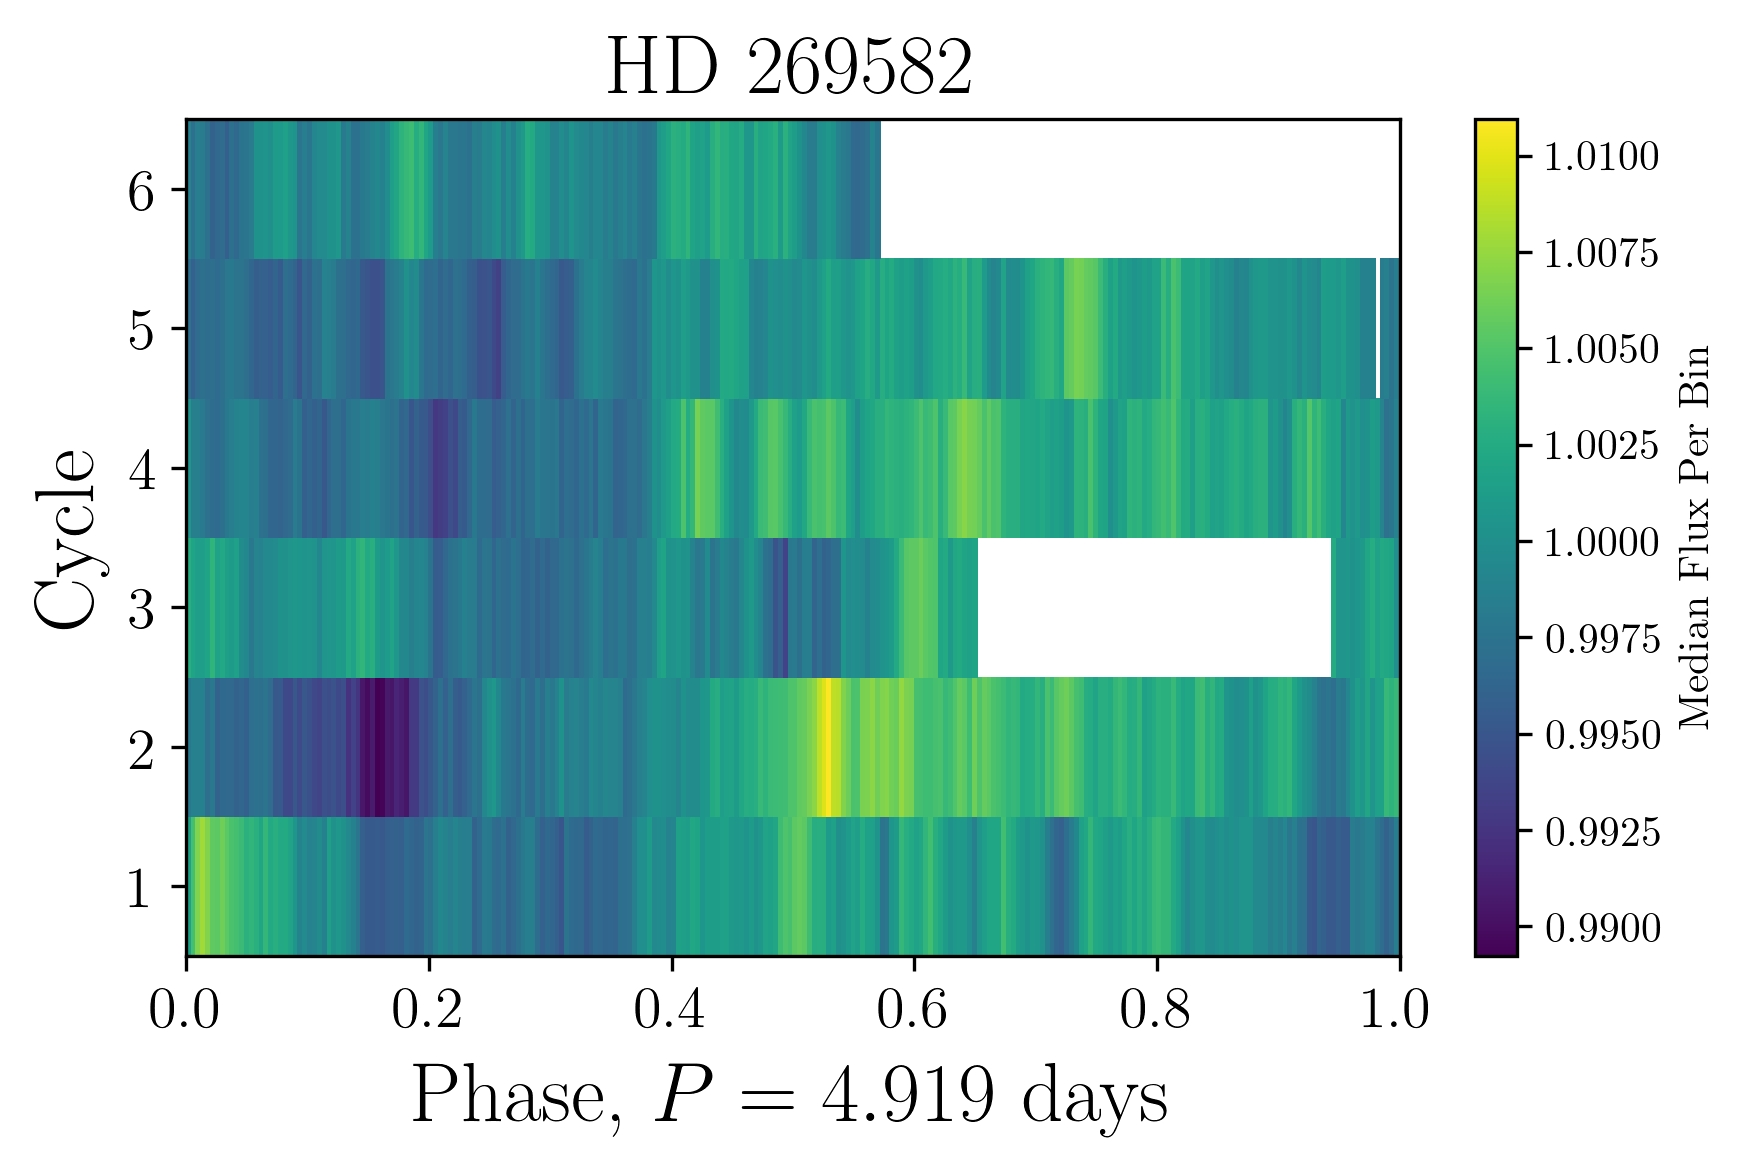

In [8]:
fig = plt.figure(dpi=300)
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux = lc['Time'], lc['Flux']
cycle = np.floor((time-np.min(time))*dom)
phase = ((time-np.min(time))*dom) % 1
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = plt.pcolormesh(XX,YY,H.T)
plt.xlabel('Phase, $P = 4.919$ days')
plt.ylabel('Cycle')
ax = plt.gca()
plt.colorbar(colobj, ax=ax, label='Median Flux Per Bin')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    

ax.set_title('HD 269582',fontsize=20)     
plt.tight_layout()   
plt.savefig('../plots/HD269582_dynamic.pdf')

Text(0.5, 1.0, 'HD 268687')

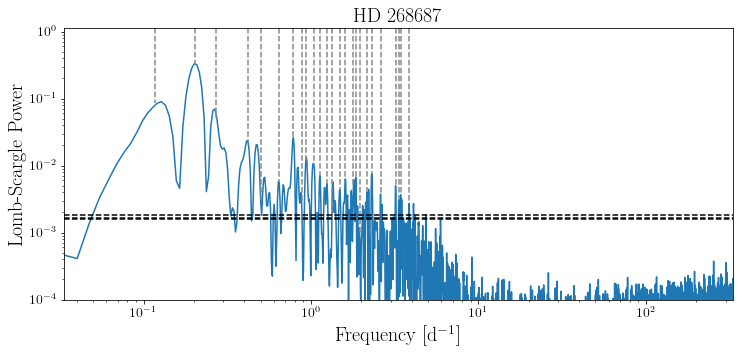

In [11]:
fig = plt.figure(figsize=(12,5))
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
ls = LombScargle(time, flux)
freq, power = ls.autopower() 
plt.loglog(freq, power)

ax = plt.gca()

ax.set(xlabel='Frequency [d$^{-1}$]',ylabel='Lomb-Scargle Power', xlim=(1/30,pseudo_NF))

ylim = ax.get_ylim()

plt.plot([good_fs[0,0],good_fs[0,0]],[ylim[1],power[np.argmin(np.abs(freq-good_fs[0,0]))]],c='#888888',ls='--',label='Prewhitening Frequencies')
for f in good_fs[1:,0]:
    plt.plot([f,f],[ylim[1],power[np.argmin(np.abs(freq-f))]],c='#888888',ls='--')
    
ax.set(ylim=(1e-4,ylim[1]))

probabilities = [0.1, 0.05, 0.01]
fal = ls.false_alarm_level(probabilities)
for f in fal:
    plt.axhline(y=f,c='k',ls='--')
        
#plt.legend(loc=1, framealpha=0.9, prop={'size': 14})

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

ax.set_title('HD 268687',fontsize=20)

In [17]:
good_fs[:,0][~np.array([power[np.argmin(np.abs(freq-f))] for f in good_fs[:,0]] >= fal[-1])]

array([1.95391049, 1.33240989])

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


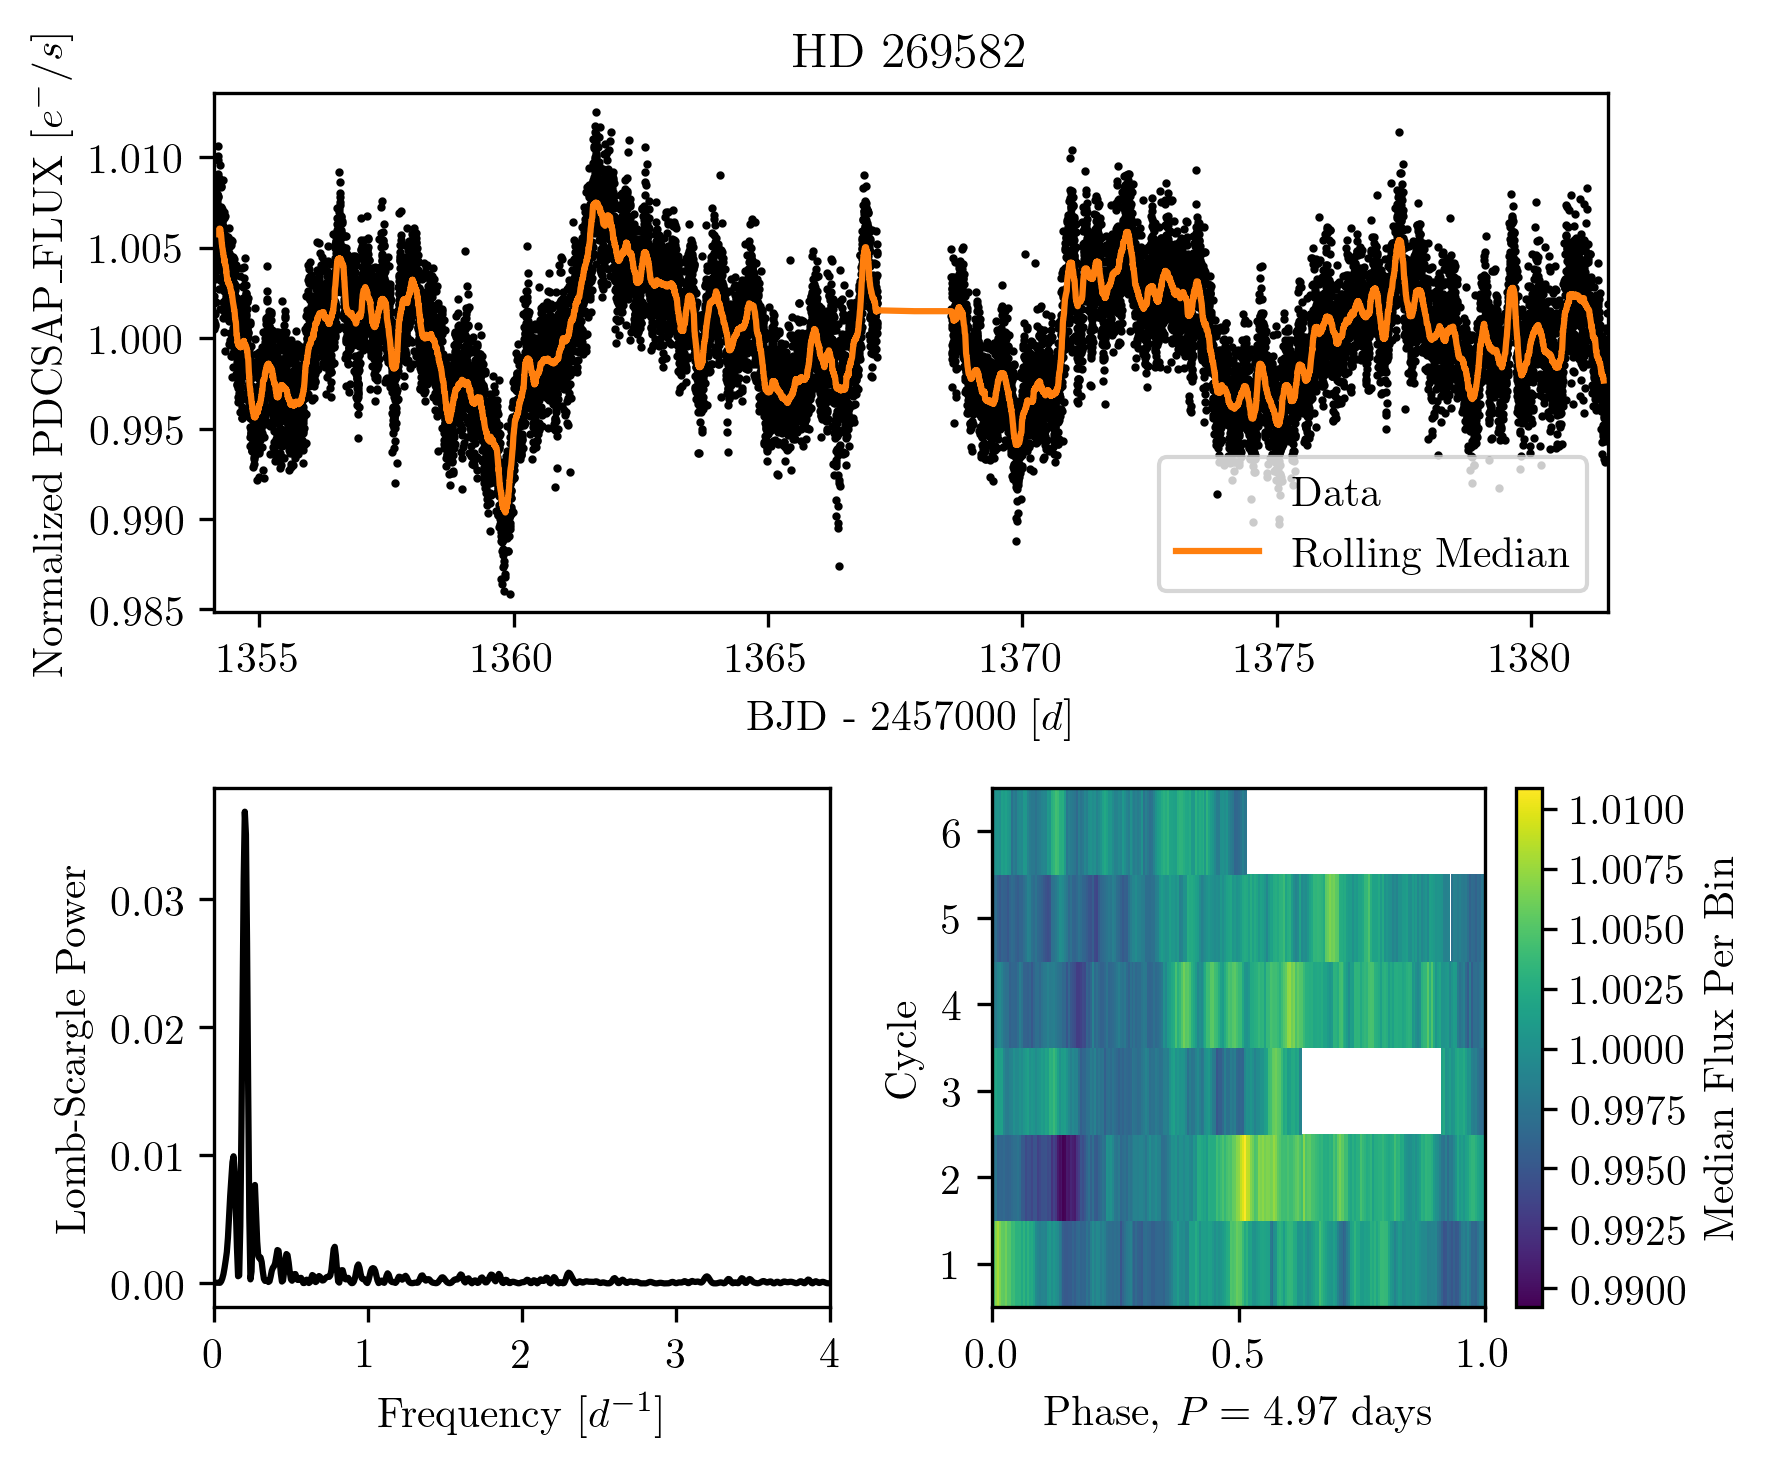

In [45]:
#Let's make a figure for the Cycle 2 proposal:
#Lightcurve
lc, lc_smooth = lc_extract(get_lc_from_id(tid), smooth=128)
#Lomb Scargle Object
ls = LombScargle(lc['Time'], lc['Flux'],normalization='psd')
pseudo_NF = 0.5 / (np.mean(np.diff(lc['Time'])))
f, p = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)

dom = f[np.argmax(p)]
dp = 1.0/dom

plt.figure(figsize=(6,5),dpi=300)
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

ax1.scatter(lc['Time'],lc['Flux'],s=1,label='Data',c='k')
ax1.plot(lc_smooth['Time'],lc_smooth['Flux'],c='C1',label='Rolling Median')
ax1.set(xlabel='BJD - 2457000 [$d$]', ylabel='Normalized PDCSAP\_FLUX [$e^-/s$]',
       xlim=(np.min(lc['Time']),np.max(lc['Time'])), 
       ylim=(0.999*np.min(lc['Flux']),1.001*np.max(lc['Flux'])),
       title='HD 269582')

h, l = ax1.get_legend_handles_labels()
ax1.legend(handles = h[::-1], labels = l[::-1])#, prop={'size': 14})

ax2.plot(f,p,c='k',lw=1.5)       
ax2.set(xlabel='Frequency [$d^{-1}$]', ylabel='Lomb-Scargle Power',xlim=(0,4))

cycle = np.floor((lc['Time']-np.min(lc['Time']))*dom)
phase = ((lc['Time']-np.min(lc['Time']))*dom) % 1
flux = lc['Flux']
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = ax3.pcolormesh(XX,YY,H.T)
ax3.set(xlabel='Phase, $P = 4.97$ days',ylabel='Cycle')
plt.colorbar(colobj, ax=ax3, label='Median Flux Per Bin')
plt.tight_layout()
plt.savefig('../../Proposals/TESS_C2/fig1a.pdf')

In [39]:
dom

0.2011915404868514

In [11]:
# Now let's do some of the GP stuff on this with twin SHOs
gp = dSHO_maxlikelihood(lc)

Initial log likelihood: 87954.42568551272
Final log likelihood: 89519.3043339297
Maximum Likelihood Soln: OrderedDict([('kernel:terms[0]:log_S0', -15.253047127104002), ('kernel:terms[0]:log_omega0', 2.8808568503497565), ('kernel:terms[1]:log_S0', -13.675418309267053), ('kernel:terms[1]:log_Q', 1.3815182716151988), ('kernel:terms[1]:log_omega0', 0.3357193196973752), ('kernel:terms[2]:log_sigma', -7.2964034434956115)])


In [12]:
omega_0 = np.exp(0.33571)
dom_gp = 2.0*np.pi/omega_0
dom_gp

4.491411719187451

/Users/carina/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


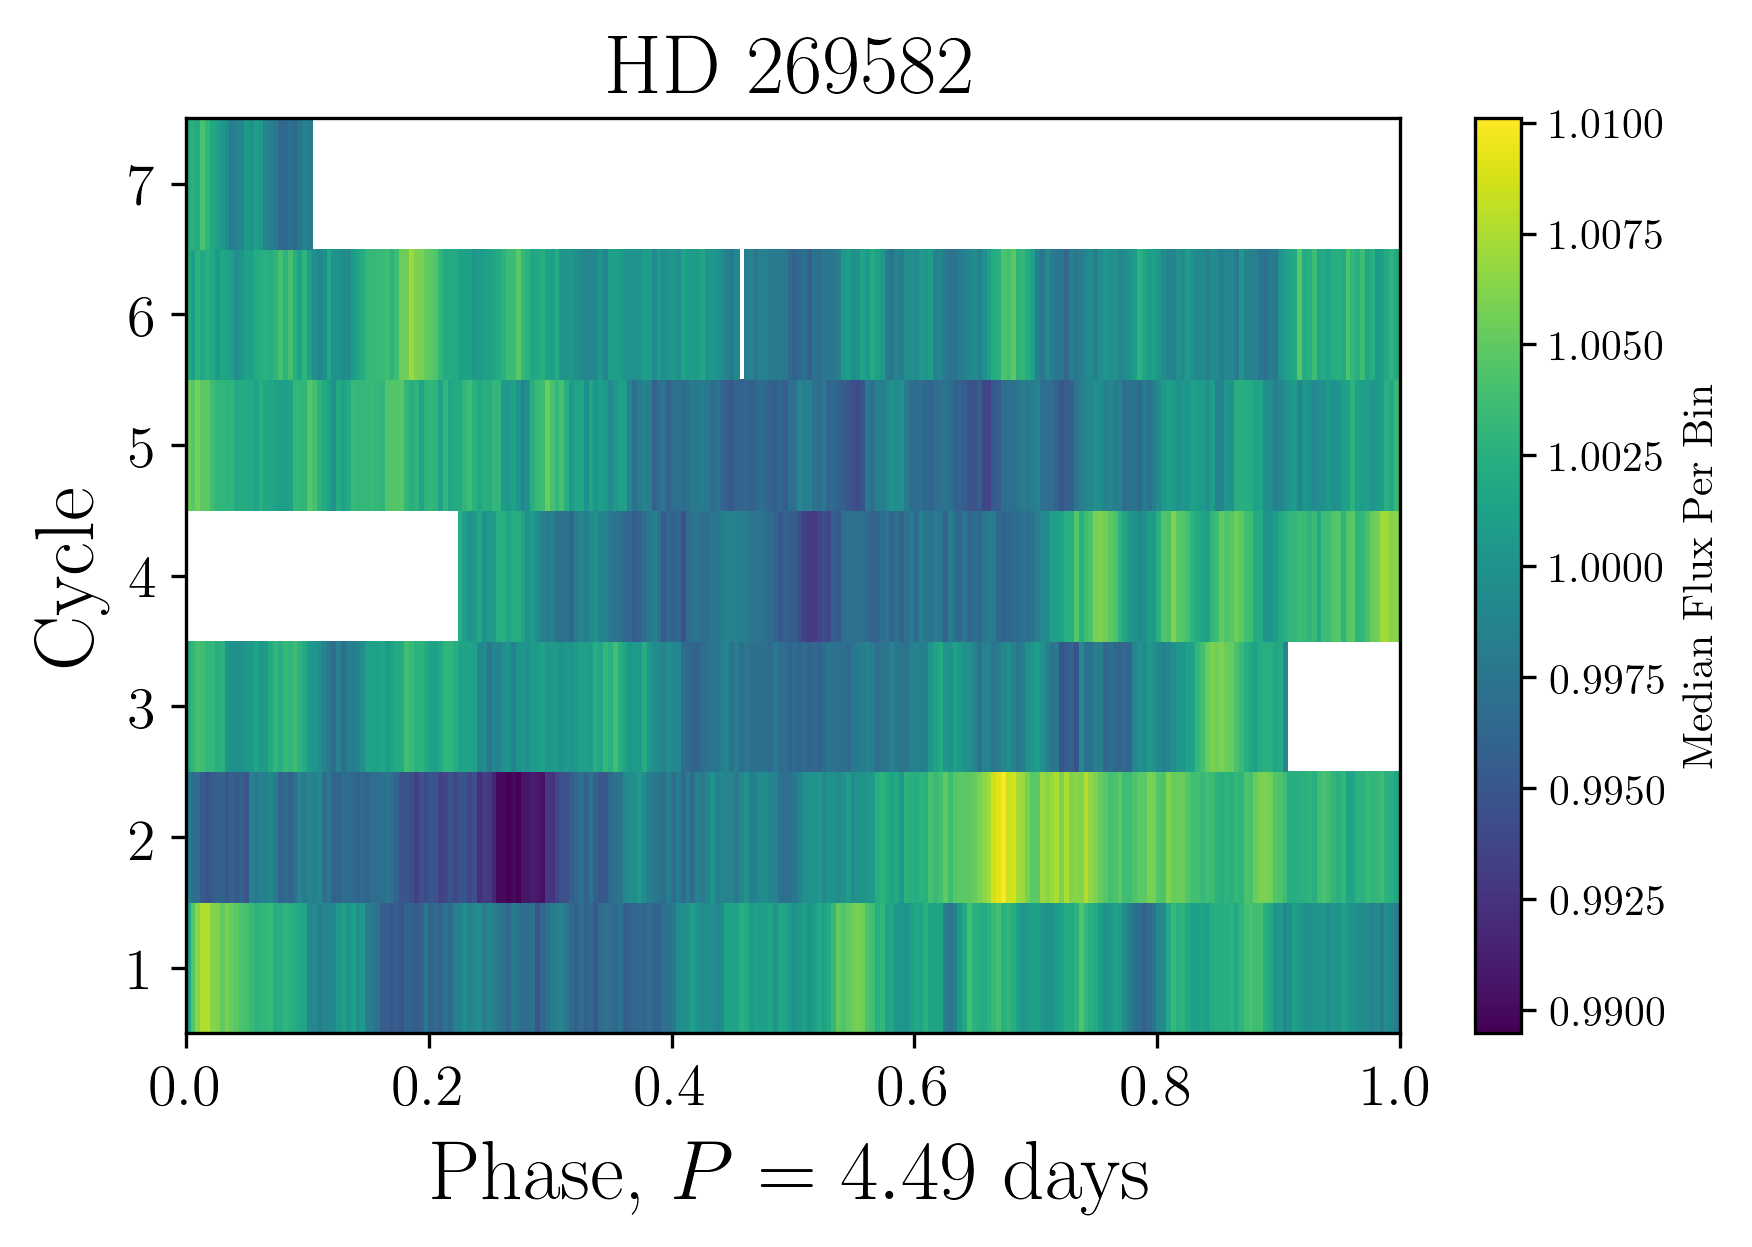

In [15]:
fig = plt.figure(dpi=300)
cycle = np.floor((lc['Time']-np.min(lc['Time']))/dom_gp)
phase = ((lc['Time']-np.min(lc['Time']))/dom_gp) % 1
flux = lc['NormFlux']
ybins = len(np.unique(cycle))
xbins = 250
H, xedges, yedges, binnumber = stats.binned_statistic_2d(phase, cycle, flux, statistic='median', bins=(xbins,ybins))  
H = np.ma.masked_where(H==0, H) #masking where there was no data
XX, YY = np.meshgrid(xedges, (ybins/(ybins-1))*yedges+0.5)
colobj = plt.pcolormesh(XX,YY,H.T)
plt.xlabel('Phase, $P = 4.49$ days')
plt.ylabel('Cycle')
ax = plt.gca()
plt.colorbar(colobj, ax=ax, label='Median Flux Per Bin')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
    
plt.tight_layout()
ax.set_title('HD 269582',fontsize=20)    
plt.savefig('../plots/HD269582_dynamicgp.pdf')

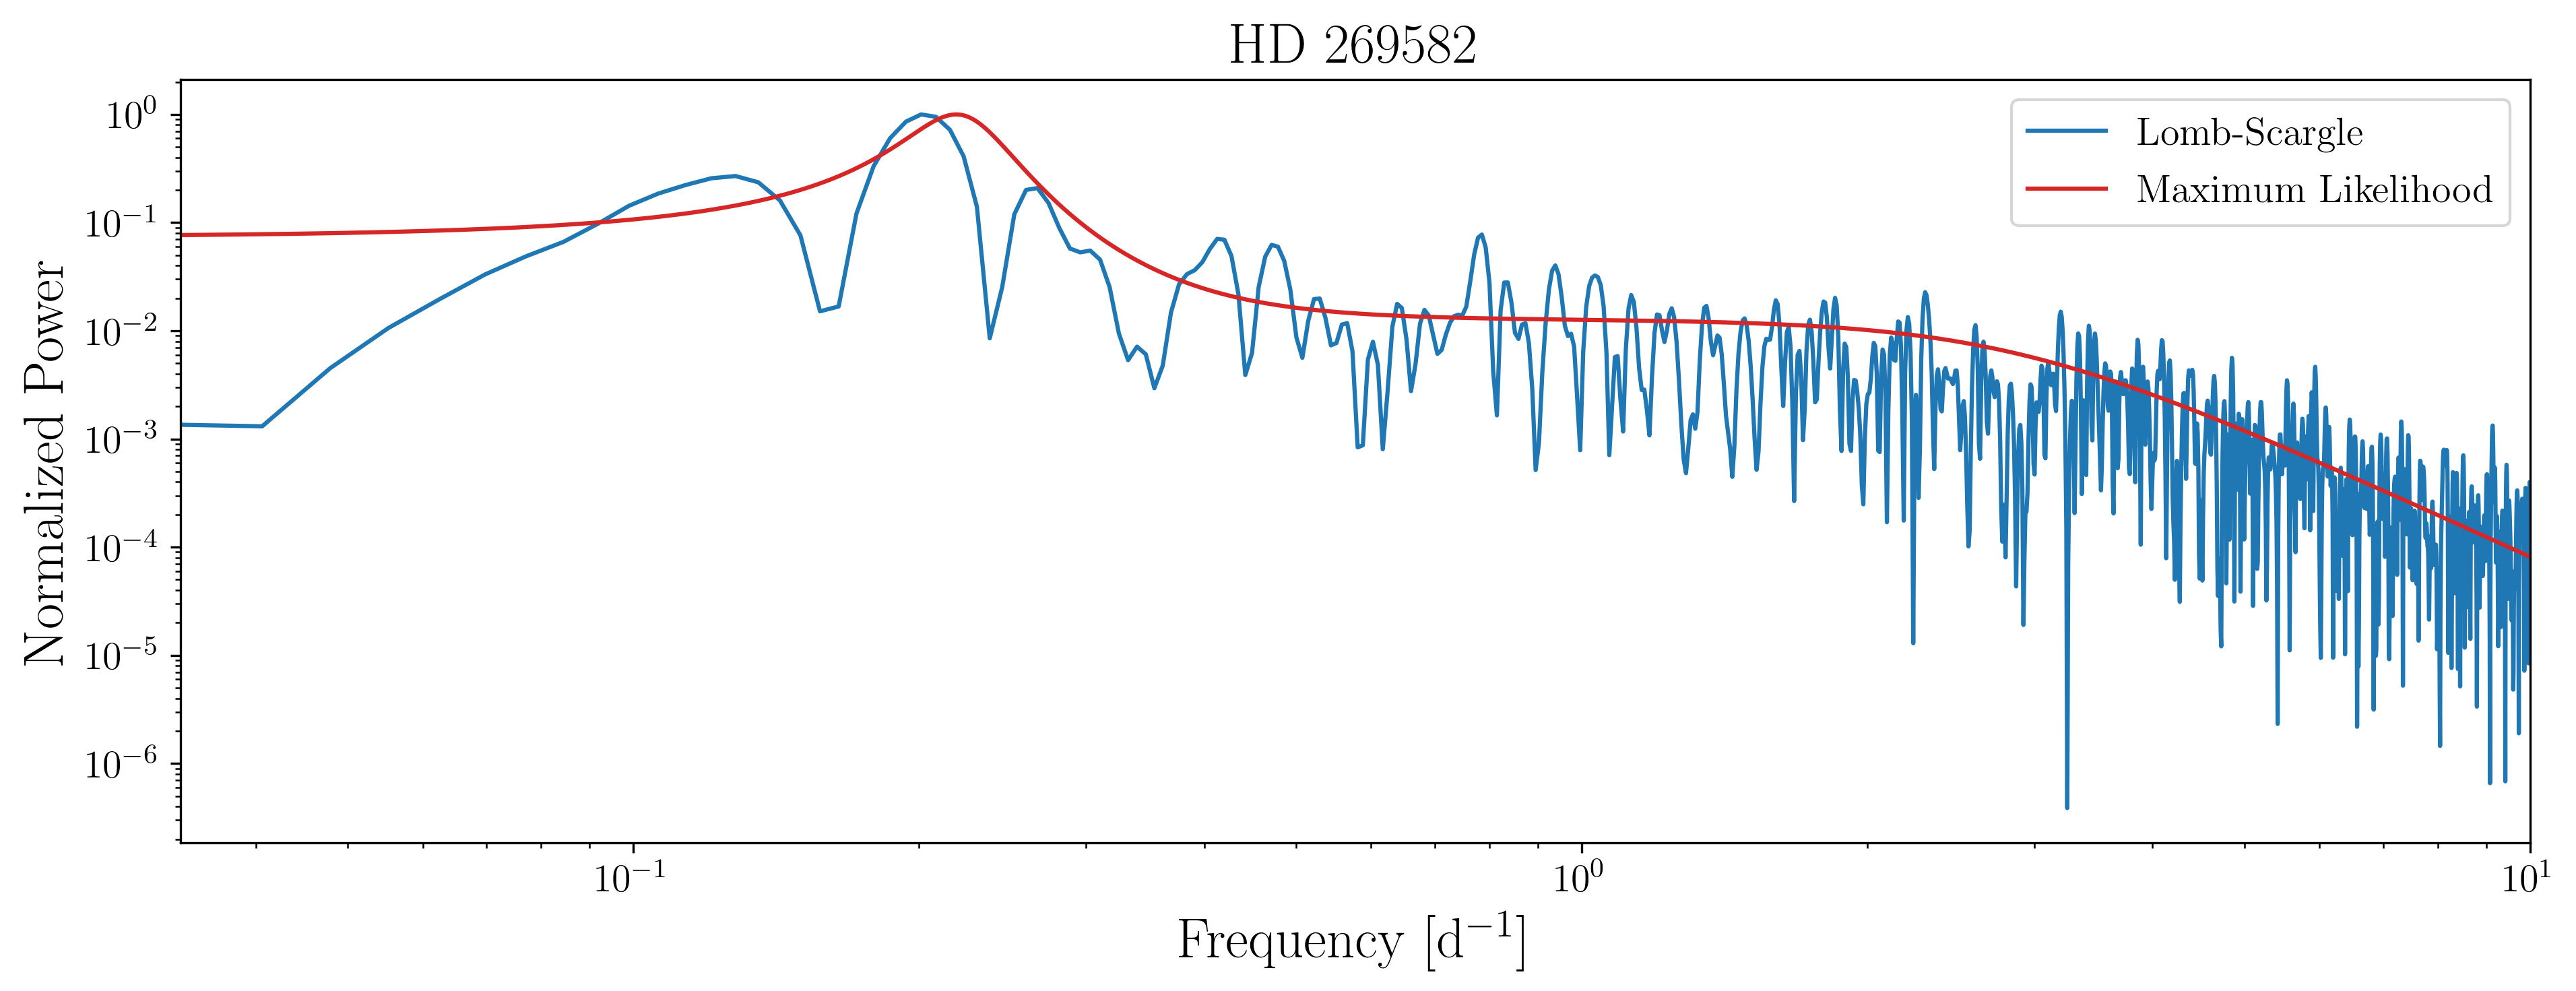

In [16]:
fig = plt.figure(figsize=(15,5),dpi=300)

omega = np.exp(np.linspace(np.log(2.0*np.pi/30.0), np.log(2.0*np.pi/0.1), 5000))
plt.loglog(f,p/np.max(p),c='C0',label='Lomb-Scargle')

psd = gp.kernel.get_psd(omega)
plt.loglog(omega/(2.0*np.pi), psd/np.max(psd), color='C3', label='Maximum Likelihood')

plt.xlabel("Frequency [d$^{-1}$]")
plt.ylabel("Normalized Power")
plt.xlim(1/30,1/0.1)
plt.legend(fontsize=14)
ax = plt.gca()
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
ax.set_title('HD 269582',fontsize=20) 
plt.savefig('../plots/HD269582_power.pdf')

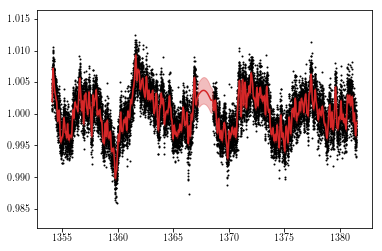

In [12]:
x = np.linspace(np.min(lc['Time']), np.max(lc['Time']), 5000)
pred_mean, pred_var = gp.predict(lc['NormFlux'], x, return_var=True)
pred_std = np.sqrt(pred_var)

plt.scatter(lc['Time'], lc['NormFlux'], s=1, c='k')
plt.plot(x, pred_mean, color='C3')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color='C3', alpha=0.3,
                 edgecolor="none")

In [21]:
sampler, gp = dSHO_emcee(lc, gp)

Running 500 steps of burn-in...
Running 3000 steps of production...


(0.03333333333333333, 10.0)

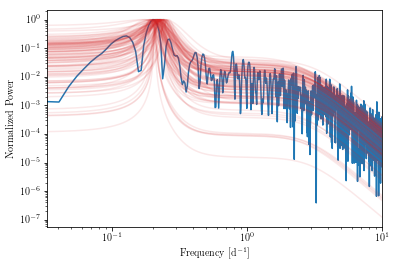

In [22]:
omega = np.exp(np.linspace(np.log(2.0*np.pi/30.0), np.log(2.0*np.pi/0.1), 5000))
plt.plot(f,p/np.max(p),c='C0')

samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=100)]:
    gp.set_parameter_vector(s)
    psd = gp.kernel.get_psd(omega)
    plt.plot(omega/(2.0*np.pi), psd/np.max(psd), alpha=0.1, color='C3')

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency [d$^{-1}$]")
plt.ylabel("Normalized Power")
plt.xlim(1/30,1/0.1)